# Hierarchical Waste Classifier - Vision Transformer

This notebook trains a **Hierarchical Vision Transformer** for waste classification:
- **30 fine-grained classes** (specific waste types)  
- **7 super categories** (Metal, Paper, Glass, Plastic, Styrofoam, Organic, Textiles)

## Quick Start
**Just run all cells in sequence** - the notebook is designed to work smoothly from top to bottom.

### Key Features:
- **Dual-head architecture** with shared ViT backbone
- **Hierarchical loss function** combining fine-grained and super-class predictions
- **Live training progress** with tqdm bars
- **Automatic model saving** and performance tracking
- **Comprehensive analysis** with confusion matrices

### Requirements:
Update the `dataset_path` in cell 4 to point to your dataset location.

## Import Libraries
Import all necessary libraries for the hierarchical waste classification project.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision.transforms import v2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import timm
from tqdm.auto import tqdm
import gc
import time
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from timm import create_model
from sklearn.metrics import confusion_matrix, classification_report

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [2]:
import os

dataset_path = '/kaggle/input/household-waste-30-classes/images/images'
#dataset_path = '/teamspace/studios/this_studio/.cache/kagglehub/datasets/alistairking/recyclable-and-household-waste-classification/versions/1/images/images'

# Check if dataset path exists
if not os.path.exists(dataset_path):
    print(f"Dataset path not found: {dataset_path}")
    print("Please update the dataset_path variable with the correct path to your dataset")
    # Set to None to prevent errors in downstream cells
    full_dataset = None
    print("⚠️  WARNING: Dataset not loaded. Please fix the path before continuing.")
else:
    print(f"Dataset path found: {dataset_path}")
    try:
        full_dataset = ImageFolder(dataset_path)
        print(f"✅ Dataset loaded successfully: {len(full_dataset)} images found")
    except Exception as e:
        print(f"❌ Error loading dataset: {e}")
        full_dataset = None

Dataset path found: /kaggle/input/household-waste-30-classes/images/images
✅ Dataset loaded successfully: 15000 images found


## Dataset Loading
Load the household waste dataset using ImageFolder. Update the `dataset_path` variable to point to your dataset location.

In [3]:
# Check if dataset was loaded successfully
if full_dataset is None:
    print("❌ Cannot proceed without dataset. Please fix the dataset path in the previous cell.")
    # Create dummy variables to prevent errors
    class_map_dict = {}
    class_names = []
else:
    class_map_dict = full_dataset.class_to_idx

    def get_class(num_label):
        for class_name, class_index in class_map_dict.items():
            if class_index == num_label:
                return class_name
        return None

    class_names = list(class_map_dict.keys())
    print(f'Number of classes: {len(class_names)}')
    
    # Verify we have the expected 30 classes
    if len(class_names) != 30:
        print(f"⚠️  WARNING: Expected 30 classes, found {len(class_names)}")
    else:
        print("✅ Correct number of classes found")

Number of classes: 30
✅ Correct number of classes found


## Hierarchical Classification System
Define the 7 super categories and create mappings between fine-grained classes (30) and super classes (7).

**Super Categories:**
- Metal & Aluminum (4 classes)
- Cardboard & Paper (6 classes) 
- Glass Containers (3 classes)
- Plastic Items (9 classes)
- Styrofoam Products (2 classes)
- Organic Waste (4 classes)
- Textiles & Clothing (2 classes)

In [4]:
# Define super-classes (7 categories)
SUPER_CLASSES = {
    0: [  # Metal_Aluminum
        'aerosol_cans',
        'aluminum_food_cans',
        'aluminum_soda_cans',
        'steel_food_cans'
    ],
    1: [  # Cardboard_Paper
        'cardboard_boxes',
        'cardboard_packaging',
        'magazines',
        'newspaper',
        'office_paper',
        'paper_cups'
    ],
    2: [  # Glass_Containers
        'glass_beverage_bottles',
        'glass_cosmetic_containers',
        'glass_food_jars'
    ],
    3: [  # Plastic_Items
        'disposable_plastic_cutlery',
        'plastic_cup_lids',
        'plastic_detergent_bottles',
        'plastic_food_containers',
        'plastic_shopping_bags',
        'plastic_soda_bottles',
        'plastic_straws',
        'plastic_trash_bags',
        'plastic_water_bottles'
    ],
    4: [  # Styrofoam_Products
        'styrofoam_cups',
        'styrofoam_food_containers'
    ],
    5: [  # Organic_Waste
        'coffee_grounds',
        'eggshells',
        'food_waste',
        'tea_bags'
    ],
    6: [  # Textiles_Clothing
        'clothing',
        'shoes'
    ]
}

SUPER_CLASS_NAMES = {
    0: 'Metal_Aluminum',
    1: 'Cardboard_Paper', 
    2: 'Glass_Containers',
    3: 'Plastic_Items',
    4: 'Styrofoam_Products',
    5: 'Organic_Waste',
    6: 'Textiles_Clothing'
}

# Initialize mappings (will be empty if dataset failed to load)
CLASS_TO_SUPER = {}
CLASS_IDX_TO_SUPER_IDX = {}
SUPER_IDX_TO_CLASS_INDICES = {i: [] for i in range(7)}

# Only build mappings if we have a valid dataset
if full_dataset is not None and len(class_names) > 0:
    # Build reverse lookup from class → super_class
    for super_id, class_list in SUPER_CLASSES.items():
        for class_name in class_list:
            CLASS_TO_SUPER[class_name] = super_id

    # Create mapping from class index to super class index
    for class_name, class_idx in class_map_dict.items():
        if class_name in CLASS_TO_SUPER:
            super_idx = CLASS_TO_SUPER[class_name]
            CLASS_IDX_TO_SUPER_IDX[class_idx] = super_idx
            SUPER_IDX_TO_CLASS_INDICES[super_idx].append(class_idx)

    def get_super_class_name(class_idx):
        """Get super class name from fine class index"""
        super_idx = CLASS_IDX_TO_SUPER_IDX.get(class_idx, -1)
        return SUPER_CLASS_NAMES.get(super_idx, 'Unknown')

    def get_super_class_idx(class_idx):
        """Get super class index from fine class index"""
        return CLASS_IDX_TO_SUPER_IDX.get(class_idx, -1)

    def convert_labels_to_super(fine_labels):
        """Convert fine-grained labels to super-class labels"""
        if isinstance(fine_labels, torch.Tensor):
            fine_labels = fine_labels.cpu().numpy()
        
        super_labels = []
        for label in fine_labels:
            super_labels.append(CLASS_IDX_TO_SUPER_IDX.get(int(label), 0))  # Default to 0 instead of -1
        
        return torch.tensor(super_labels) if torch.is_tensor(torch.tensor(fine_labels)) else np.array(super_labels)

    # Validation and Summary
    print(f"Hierarchical Classification Setup Complete:")
    print(f"• Fine-grained classes: {len(class_names)}")
    print(f"• Super classes: {len(SUPER_CLASS_NAMES)}")

    # Verify all classes are mapped
    unmapped_classes = [c for c in class_names if c not in CLASS_TO_SUPER]
    if unmapped_classes:
        print(f"⚠️  WARNING: {len(unmapped_classes)} unmapped classes found: {unmapped_classes}")
        # This could cause issues in training
    else:
        print("✅ All classes successfully mapped to super categories")
    
    # Verify expected class counts per super category
    expected_counts = {0: 4, 1: 6, 2: 3, 3: 9, 4: 2, 5: 4, 6: 2}
    for super_idx, expected_count in expected_counts.items():
        actual_count = len(SUPER_IDX_TO_CLASS_INDICES[super_idx])
        if actual_count != expected_count:
            print(f"⚠️  WARNING: Super class {super_idx} ({SUPER_CLASS_NAMES[super_idx]}) has {actual_count} classes, expected {expected_count}")
        else:
            print(f"✅ Super class {super_idx} ({SUPER_CLASS_NAMES[super_idx]}) has correct count: {actual_count}")
            
else:
    print("❌ Cannot create class mappings without valid dataset")
    # Define dummy functions to prevent errors
    def get_super_class_name(class_idx):
        return 'Unknown'
    
    def get_super_class_idx(class_idx):
        return 0
    
    def convert_labels_to_super(fine_labels):
        return torch.zeros(len(fine_labels))

Hierarchical Classification Setup Complete:
• Fine-grained classes: 30
• Super classes: 7
✅ All classes successfully mapped to super categories
✅ Super class 0 (Metal_Aluminum) has correct count: 4
✅ Super class 1 (Cardboard_Paper) has correct count: 6
✅ Super class 2 (Glass_Containers) has correct count: 3
✅ Super class 3 (Plastic_Items) has correct count: 9
✅ Super class 4 (Styrofoam_Products) has correct count: 2
✅ Super class 5 (Organic_Waste) has correct count: 4
✅ Super class 6 (Textiles_Clothing) has correct count: 2


## Data Processing & Augmentation
Set up data transformations, train/test split, and create data loaders with augmentation for training.

In [5]:
# Check if we have a valid dataset before proceeding
if full_dataset is None:
    print("❌ Cannot create data loaders without valid dataset")
    # Create dummy variables to prevent errors in downstream cells
    train_loader = None
    test_loader = None
    train_dataset_transformed = None
    test_dataset_transformed = None
else:
    # Data Splitting and Loading - Fixed for multiprocessing compatibility
    batch_size = 64
    num_workers = 0  # Set to 0 to avoid multiprocessing issues with custom classes
    train_size = int(0.8 * len(full_dataset))
    test_size = len(full_dataset) - train_size

    # Data transformations
    train_transform = v2.Compose([
        v2.RandomResizedCrop(224, scale=(0.7, 1.0)),
        v2.RandomHorizontalFlip(p=0.5),
        v2.RandomVerticalFlip(p=0.5),
        v2.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
        v2.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
        v2.RandomErasing(p=0.3, scale=(0.02, 0.33), ratio=(0.3, 3.3)),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    test_transform = v2.Compose([
        v2.Resize((224, 224)),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Simple wrapper class for transforms - avoid multiprocessing issues
    class SimpleTransformWrapper(Dataset):
        def __init__(self, dataset, transform=None):
            self.dataset = dataset
            self.transform = transform

        def __getitem__(self, index):
            image, target = self.dataset[index]
            if self.transform:
                image = self.transform(image)
            return image, target

        def __len__(self):
            return len(self.dataset)

    try:
        # Split dataset
        torch.manual_seed(42)
        train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

        # Apply transforms
        train_dataset_transformed = SimpleTransformWrapper(train_dataset, transform=train_transform)
        test_dataset_transformed = SimpleTransformWrapper(test_dataset, transform=test_transform)

        # Create data loaders with num_workers=0 to avoid multiprocessing issues
        train_loader = DataLoader(train_dataset_transformed, batch_size=batch_size, shuffle=True, num_workers=0)
        test_loader = DataLoader(test_dataset_transformed, batch_size=batch_size, shuffle=False, num_workers=0)

        print(f"✅ Dataset split: {len(train_dataset_transformed)} train, {len(test_dataset_transformed)} test samples")
        print(f"✅ Data loaders created: {len(train_loader)} train batches, {len(test_loader)} test batches")
        
    except Exception as e:
        print(f"❌ Error creating data loaders: {e}")
        train_loader = None
        test_loader = None
        train_dataset_transformed = None
        test_dataset_transformed = None

✅ Dataset split: 12000 train, 3000 test samples
✅ Data loaders created: 188 train batches, 47 test batches


## Sample Images Visualization
Display a grid of sample images from the dataset to understand the variety and quality of waste classification data.

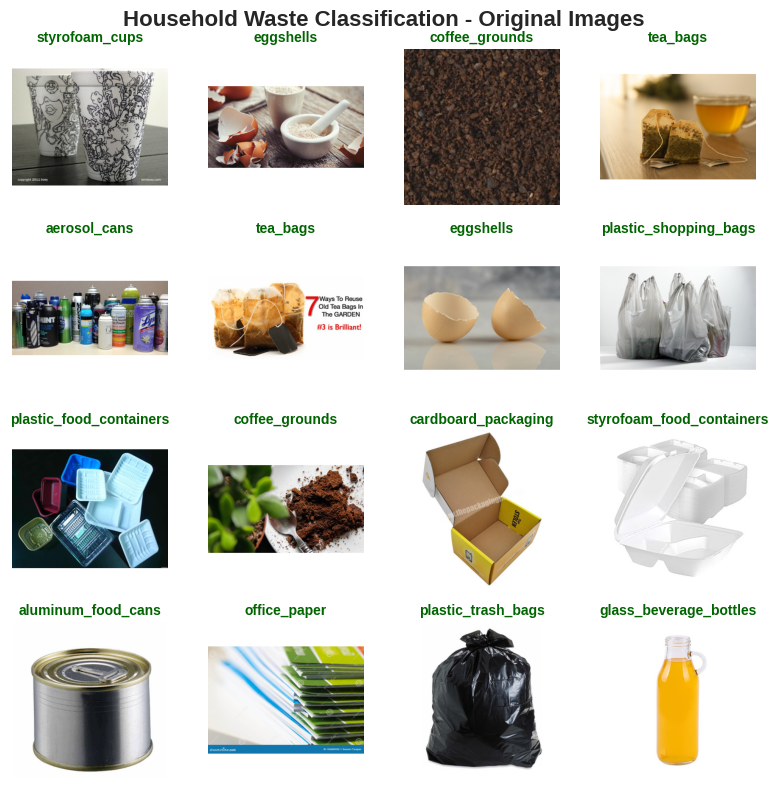

In [6]:
# Display original images from the full dataset (no transformations)
sns.set_style("whitegrid")
plt.style.use("seaborn-v0_8")

fig, axes = plt.subplots(4, 4, figsize=(8, 8))
fig.suptitle('Household Waste Classification - Original Images', fontsize=16, fontweight='bold')

# Get 16 random samples
sample_indices = random.sample(range(len(full_dataset)), 16)

for i, idx in enumerate(sample_indices):
    row = i // 4
    col = i % 4

    original_img, label = full_dataset[idx]
    img_array = np.array(original_img)

    axes[row, col].imshow(img_array)
    axes[row, col].set_title(f"{get_class(label)}",
                            fontsize=10, fontweight='semibold',
                            color='darkgreen')
    axes[row, col].axis("off")

    for spine in axes[row, col].spines.values():
        spine.set_edgecolor(sns.color_palette("Set2", 8)[label % 8])
        spine.set_linewidth(2)

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()
plt.style.use('default')
sns.reset_defaults()

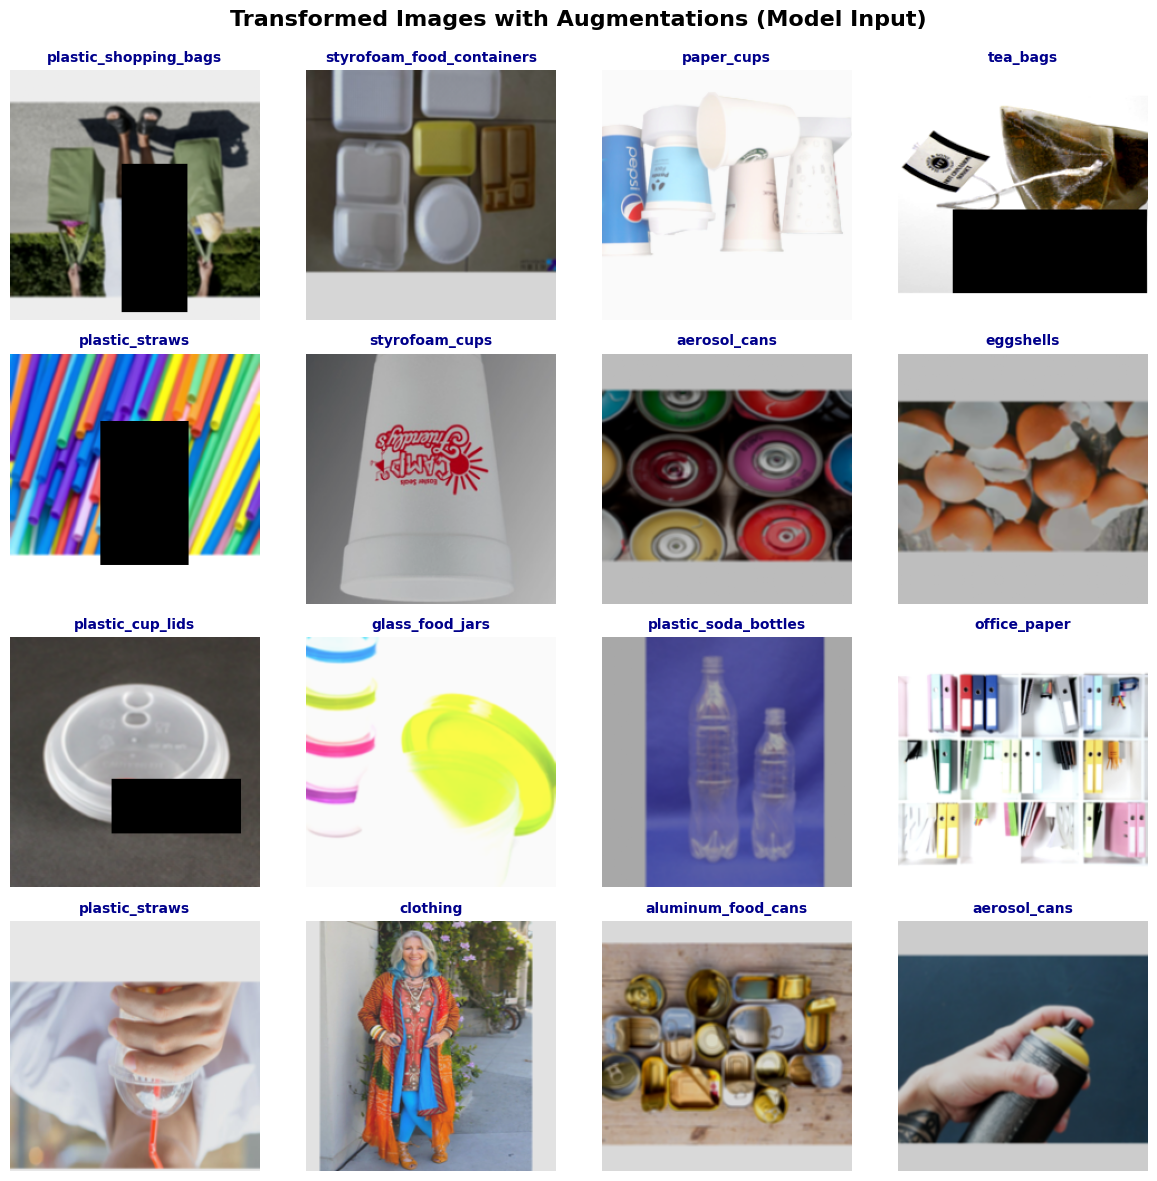

Note: These transformed images show the effects of data augmentation:
• Random crops and resizing
• Horizontal/vertical flips
• Color jitter (brightness, contrast, saturation)
• Gaussian blur and random erasing
• Normalization for model input


In [7]:
# Display transformed images (with augmentations) that will be fed to the model
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
fig.suptitle('Transformed Images with Augmentations (Model Input)', fontsize=16, fontweight='bold')

# Get 16 random samples from training dataset (with transforms)
sample_indices = random.sample(range(len(train_dataset_transformed)), 16)

for i, idx in enumerate(sample_indices):
    row = i // 4
    col = i % 4
    
    # Get transformed image and label
    transformed_img, label = train_dataset_transformed[idx]
    
    # Convert from tensor back to displayable format
    # Denormalize the image (reverse the normalization)
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    
    # Denormalize
    img_denorm = transformed_img.clone()
    for t, m, s in zip(img_denorm, mean, std):
        t.mul_(s).add_(m)
    
    # Clamp to valid range and convert to numpy
    img_denorm = torch.clamp(img_denorm, 0, 1)
    img_array = img_denorm.permute(1, 2, 0).numpy()
    
    axes[row, col].imshow(img_array)
    axes[row, col].set_title(f"{get_class(label)}", 
                            fontsize=10, fontweight='semibold',
                            color='darkblue')
    axes[row, col].axis("off")
    
    # Add colored border
    for spine in axes[row, col].spines.values():
        spine.set_edgecolor(sns.color_palette("Set1", 8)[label % 8])
        spine.set_linewidth(2)

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

print("Note: These transformed images show the effects of data augmentation:")
print("• Random crops and resizing")
print("• Horizontal/vertical flips")
print("• Color jitter (brightness, contrast, saturation)")
print("• Gaussian blur and random erasing")
print("• Normalization for model input")

## Model Architecture
Define the Vision Transformer models including both single-head and hierarchical dual-head architectures.

In [8]:
# Option 1: Standard ViT-Base 
def make_vit_base(num_classes=30):
    model = timm.create_model('vit_base_patch16_224', pretrained=True)
    model.head = nn.Linear(model.head.in_features, num_classes)
    return model

# Option 2: More robust - Hybrid ViT approach (recommended)
class HybridViT(nn.Module):
    def __init__(self, num_classes=30, dropout=0.3):
        super().__init__()
        self.vit = timm.create_model('vit_small_patch16_224', pretrained=True)
        self.vit.head = nn.Identity()  # Remove original head
        
        # Add robust classification head
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(384, 256),  # ViT-Small has 384 features
            nn.ReLU(),
            nn.Dropout(dropout * 0.7),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        features = self.vit(x)
        return self.classifier(features)

# Focal Loss for handling class imbalance
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, label_smoothing=0.1):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.label_smoothing = label_smoothing
        
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, label_smoothing=self.label_smoothing, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

print("Model architectures defined successfully")

Model architectures defined successfully


In [9]:
# Hierarchical Vision Transformer Model (Updated for 7 Super Classes)

class HierarchicalViT(nn.Module):
    """
    Hierarchical Vision Transformer for waste classification
    
    Architecture:
    - Shared ViT backbone (pretrained vit_small_patch16_224)
    - Dual prediction heads:
      • Fine-grained: 30 waste classes
      • Super-class: 7 categories (Metal, Paper, Glass, Plastic, Styrofoam, Organic, Textiles)
    
    Training Strategy:
    - Phase 1: Freeze backbone, train heads only
    - Phase 2: Fine-tune last transformer blocks + heads
    """
    
    def __init__(self, 
                 num_fine_classes=30, 
                 num_super_classes=7,  # Updated from 6 to 7
                 model_name='vit_small_patch16_224',
                 pretrained=True,
                 dropout=0.1):
        super().__init__()
        
        self.num_fine_classes = num_fine_classes
        self.num_super_classes = num_super_classes
        
        # Load pretrained ViT backbone
        self.backbone = create_model(
            model_name, 
            pretrained=pretrained,
            num_classes=0  # Remove classification head
        )
        
        # Get feature dimension
        feature_dim = self.backbone.num_features  # 384 for vit_small
        
        # Shared feature processing
        self.feature_processor = nn.Sequential(
            nn.LayerNorm(feature_dim),
            nn.Dropout(dropout),
        )
        
        # Fine-grained classification head (30 classes)
        self.fine_classifier = nn.Sequential(
            nn.Linear(feature_dim, feature_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(feature_dim // 2, num_fine_classes)
        )
        
        # Super-class classification head (7 classes) - Updated
        self.super_classifier = nn.Sequential(
            nn.Linear(feature_dim, feature_dim // 4),
            nn.GELU(), 
            nn.Dropout(dropout),
            nn.Linear(feature_dim // 4, num_super_classes)  # Changed from 6 to 7
        )
        
        # Initialize heads with Xavier initialization
        self._initialize_heads()
    
    def _initialize_heads(self):
        """Initialize classification heads"""
        for module in [self.fine_classifier, self.super_classifier]:
            for layer in module:
                if isinstance(layer, nn.Linear):
                    nn.init.xavier_uniform_(layer.weight)
                    nn.init.constant_(layer.bias, 0)
    
    def forward(self, x):
        """
        Forward pass with dual outputs
        
        Args:
            x: Input images [batch_size, 3, 224, 224]
            
        Returns:
            fine_logits: Fine-grained predictions [batch_size, 30]
            super_logits: Super-class predictions [batch_size, 7]  # Updated comment
        """
        # Extract features from ViT backbone
        features = self.backbone(x)  # [batch_size, feature_dim]
        
        # Process shared features
        processed_features = self.feature_processor(features)
        
        # Dual predictions
        fine_logits = self.fine_classifier(processed_features)     # [batch_size, 30]
        super_logits = self.super_classifier(processed_features)   # [batch_size, 7] - Updated
        
        return fine_logits, super_logits
    
    def freeze_backbone(self):
        """Freeze backbone parameters for Phase 1 training"""
        for param in self.backbone.parameters():
            param.requires_grad = False
    
    def unfreeze_last_blocks(self, num_blocks=2):
        """Unfreeze last transformer blocks for Phase 2 training"""
        # First freeze everything
        self.freeze_backbone()
        
        # Then unfreeze last few blocks
        if hasattr(self.backbone, 'blocks'):
            for block in self.backbone.blocks[-num_blocks:]:
                for param in block.parameters():
                    param.requires_grad = True
        
        # Always unfreeze norm and head if they exist
        if hasattr(self.backbone, 'norm'):
            for param in self.backbone.norm.parameters():
                param.requires_grad = True
    
    def unfreeze_all(self):
        """Unfreeze all parameters"""
        for param in self.parameters():
            param.requires_grad = True
    
    def get_trainable_params(self):
        """Get count of trainable parameters"""
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        return trainable_params, total_params

# Create model instance with proper device detection
device = torch.device('mps' if torch.backends.mps.is_available() else 
                     ('cuda' if torch.cuda.is_available() else 'cpu'))

# Create the hierarchical model (this will be our main model)
waste_classifier = HierarchicalViT(
    num_fine_classes=30,
    num_super_classes=7,
    dropout=0.3
).to(device)

print(f"HierarchicalViT model created on {device}")

# Test forward pass
with torch.no_grad():
    test_input = torch.randn(2, 3, 224, 224).to(device)
    fine_out, super_out = waste_classifier(test_input)

trainable, total = waste_classifier.get_trainable_params()
print(f"Model parameters: {total:,} total, {trainable:,} trainable")

model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

HierarchicalViT model created on cuda
Model parameters: 21,783,781 total, 21,783,781 trainable


## Hierarchical Vision Transformer
The main model with dual classification heads:
- **Fine-grained head**: Predicts specific waste types (30 classes)
- **Super-class head**: Predicts general categories (7 classes)

This allows the model to learn both detailed and general representations.

In [10]:
# Loss Functions for Hierarchical Classification (Updated for 7 Super Classes)

class FocalLoss(nn.Module):
    """
    Focal Loss for handling class imbalance
    """
    def __init__(self, alpha=1, gamma=2, num_classes=None):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.num_classes = num_classes
        
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        return focal_loss.mean()

class HierarchicalLoss(nn.Module):
    """
    Hierarchical loss combining fine-grained and super-class predictions
    Updated for 7 super classes
    """
    def __init__(self, 
                 fine_weight=0.7, 
                 super_weight=0.3,
                 num_super_classes=7,  # Updated from 6 to 7
                 focal_gamma=2.0):
        super().__init__()
        self.fine_weight = fine_weight
        self.super_weight = super_weight
        self.num_super_classes = num_super_classes
        
        # Use focal loss for both fine and super classification
        self.fine_loss = FocalLoss(gamma=focal_gamma, num_classes=30)
        self.super_loss = FocalLoss(gamma=focal_gamma, num_classes=num_super_classes)
        
    def forward(self, fine_logits, super_logits, fine_targets, super_targets):
        """
        Compute hierarchical loss
        
        Args:
            fine_logits: [batch_size, 30] fine-grained predictions
            super_logits: [batch_size, 7] super-class predictions  # Updated comment
            fine_targets: [batch_size] fine-grained ground truth
            super_targets: [batch_size] super-class ground truth
        """
        # Ensure targets are long tensors
        fine_targets = fine_targets.long()
        super_targets = super_targets.long()
        
        # Compute individual losses
        loss_fine = self.fine_loss(fine_logits, fine_targets)
        loss_super = self.super_loss(super_logits, super_targets)
        
        # Weighted combination
        total_loss = self.fine_weight * loss_fine + self.super_weight * loss_super
        
        return total_loss, loss_fine, loss_super

# Create loss functions
criterion = FocalLoss(alpha=1, gamma=2, num_classes=30)
criterion_hierarchical = HierarchicalLoss(
    fine_weight=0.7,     # 70% weight on fine-grained accuracy
    super_weight=0.3,    # 30% weight on super-class accuracy
    num_super_classes=7, # Updated from 6 to 7
    focal_gamma=2.0      # Focal loss gamma parameter
)

print("Loss functions initialized successfully")

Loss functions initialized successfully


## Loss Functions
Define specialized loss functions for hierarchical training:
- **Focal Loss**: Handles class imbalance by focusing on hard examples
- **Hierarchical Loss**: Combines fine-grained and super-class losses with configurable weights

In [11]:
# Comprehensive Setup Validation
print("🔍 SETUP VALIDATION")
print("=" * 50)

checks = [
    ('Dataset loaded', full_dataset is not None),
    ('Class mappings', len(CLASS_IDX_TO_SUPER_IDX) > 0),
    ('Model created', 'waste_classifier' in globals()),
    ('Loss function', 'criterion_hierarchical' in globals()),
    ('Data loaders', train_loader is not None and test_loader is not None),
    ('Transforms applied', train_dataset_transformed is not None)
]

all_good = True
for name, condition in checks:
    status = "✅" if condition else "❌"
    print(f"{status} {name}: {'Ready' if condition else 'Missing/Failed'}")
    if not condition:
        all_good = False

if all_good:
    print(f"\n🎉 Setup complete - Ready for training on {device}")
    print(f"📊 Training samples: {len(train_dataset_transformed):,}")
    print(f"📊 Test samples: {len(test_dataset_transformed):,}")
    print(f"📊 Fine-grained classes: {len(class_names)}")
    print(f"📊 Super classes: {len(SUPER_CLASS_NAMES)}")
else:
    missing = [name for name, condition in checks if not condition]
    print(f"\n⚠️  Issues found with: {', '.join(missing)}")
    print("Please resolve the issues above before proceeding to training.")

🔍 SETUP VALIDATION
✅ Dataset loaded: Ready
✅ Class mappings: Ready
✅ Model created: Ready
✅ Loss function: Ready
✅ Data loaders: Ready
✅ Transforms applied: Ready

🎉 Setup complete - Ready for training on cuda
📊 Training samples: 12,000
📊 Test samples: 3,000
📊 Fine-grained classes: 30
📊 Super classes: 7


## Training Setup & Validation
Verify that all components are properly initialized and ready for training. This includes model, loss functions, data loaders, and device setup.

In [12]:
# Hierarchical Training Functions (Complete)

def train_epoch_hierarchical(model, train_loader, criterion_hierarchical, optimizer, device):
    """Streamlined training function with clean tqdm progress"""
    model.train()
    total_loss = 0
    fine_correct = 0
    super_correct = 0
    total_samples = 0
    
    # Use tqdm with proper cleanup
    pbar = tqdm(train_loader, desc="Training", leave=False, position=0, dynamic_ncols=True)
    
    try:
        for images, fine_labels in pbar:
            # Move to device
            images = images.to(device)
            fine_labels = fine_labels.to(device)
            
            # Convert to super labels
            super_labels = torch.tensor([
                CLASS_IDX_TO_SUPER_IDX.get(int(label), 0) for label in fine_labels.cpu()
            ]).to(device)
            
            # Forward pass
            fine_logits, super_logits = model(images)
            loss, fine_loss, super_loss = criterion_hierarchical(
                fine_logits, super_logits, fine_labels, super_labels
            )
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            # Calculate accuracy
            _, fine_pred = torch.max(fine_logits, 1)
            _, super_pred = torch.max(super_logits, 1)
            
            fine_correct += (fine_pred == fine_labels).sum().item()
            super_correct += (super_pred == super_labels).sum().item()
            total_samples += images.size(0)
            total_loss += loss.item()
            
            # Update progress bar
            pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Fine': f'{100*fine_correct/total_samples:.1f}%',
                'Super': f'{100*super_correct/total_samples:.1f}%'
            })
    finally:
        # Ensure progress bar is properly closed
        pbar.close()
    
    return total_loss/len(train_loader), 100*fine_correct/total_samples, 100*super_correct/total_samples

def eval_epoch_hierarchical(model, test_loader, criterion_hierarchical, device):
    """Streamlined evaluation function with clean tqdm progress"""
    model.eval()
    total_loss = 0
    fine_correct = 0
    super_correct = 0
    total_samples = 0
    
    # Use tqdm with proper cleanup
    pbar = tqdm(test_loader, desc="Validation", leave=False, position=0, dynamic_ncols=True)
    
    try:
        with torch.no_grad():
            for images, fine_labels in pbar:
                # Move to device
                images = images.to(device)
                fine_labels = fine_labels.to(device)
                
                # Convert to super labels
                super_labels = torch.tensor([
                    CLASS_IDX_TO_SUPER_IDX.get(int(label), 0) for label in fine_labels.cpu()
                ]).to(device)
                
                # Forward pass
                fine_logits, super_logits = model(images)
                loss, _, _ = criterion_hierarchical(
                    fine_logits, super_logits, fine_labels, super_labels
                )
                
                # Calculate accuracy
                _, fine_pred = torch.max(fine_logits, 1)
                _, super_pred = torch.max(super_logits, 1)
                
                fine_correct += (fine_pred == fine_labels).sum().item()
                super_correct += (super_pred == super_labels).sum().item()
                total_samples += images.size(0)
                total_loss += loss.item()
                
                # Update progress bar
                pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Fine': f'{100*fine_correct/total_samples:.1f}%',
                    'Super': f'{100*super_correct/total_samples:.1f}%'
                })
    finally:
        # Ensure progress bar is properly closed
        pbar.close()
    
    return total_loss/len(test_loader), 100*fine_correct/total_samples, 100*super_correct/total_samples

print("Training functions defined successfully")

Training functions defined successfully


## Training Functions
Define streamlined training and validation functions with tqdm progress bars for real-time monitoring of loss and accuracy.

In [13]:
# Progressive Fine-tuning Training Execution
print("Starting Progressive Fine-tuning Training")
print("="*60)

# Pre-training Validation
print("🔍 Pre-training Validation...")

# Check critical components
critical_checks = [
    ("Dataset", full_dataset is not None),
    ("Class mappings", len(CLASS_IDX_TO_SUPER_IDX) > 0),
    ("Model", 'waste_classifier' in globals()),
    ("Loss function", 'criterion_hierarchical' in globals()),
    ("Data loaders", train_loader is not None and test_loader is not None)
]

validation_failed = False
for check_name, condition in critical_checks:
    if not condition:
        print(f"❌ {check_name} validation failed")
        validation_failed = True
    else:
        print(f"✅ {check_name} validated")

if validation_failed:
    print("🛑 TRAINING ABORTED: Critical components missing or failed.")
    print("Please run the setup cells above to resolve issues.")
else:
    print("✅ All validations passed. Proceeding with training...")

    # Setup
    print(f"Device: {device}")
    waste_classifier = waste_classifier.to(device)

    # Progressive Training Configuration
    PHASE_CONFIGS = {
        1: {
            'name': 'Phase 1: Frozen Backbone + Classification Heads',
            'epochs': 5,
            'lr': 1e-3,
            'min_lr': 1e-4,
            'freeze_backbone': True,
            'unfreeze_blocks': 0
        },
        2: {
            'name': 'Phase 2: Last 4 Transformer Blocks + Heads',
            'epochs': 10,
            'lr': 5e-4,
            'min_lr': 1e-5,
            'freeze_backbone': False,
            'unfreeze_blocks': 4
        },
        3: {
            'name': 'Phase 3: Full Model Fine-tuning',
            'epochs': 5,
            'lr': 1e-5,
            'min_lr': 1e-6,
            'freeze_backbone': False,
            'unfreeze_blocks': -1  # -1 means unfreeze all
        }
    }

    # Ensure data loaders exist and work
    print("Validating data loaders...")
    try:
        test_batch = next(iter(train_loader))
        print(f"✅ Using data loaders: {len(train_loader)} train, {len(test_loader)} test batches")
    except Exception as e:
        print(f"❌ Data loader validation failed: {e}")
        print("🛑 TRAINING ABORTED: Data loaders not working.")
        validation_failed = True

    if not validation_failed:
        # Global training history
        all_train_losses, all_val_losses = [], []
        all_train_fine_accs, all_val_fine_accs = [], []
        all_train_super_accs, all_val_super_accs = [], []
        phase_boundaries = []  # Track where each phase ends
        best_val_acc = 0
        global_epoch = 0

        print(f"\nDataset: {len(train_loader)} train batches, {len(test_loader)} val batches")
        print(f"Model: {waste_classifier.__class__.__name__} on {device}")

        # Execute Progressive Training Phases
        for phase_num, config in PHASE_CONFIGS.items():
            print("\n" + "="*80)
            print(f"{config['name']}")
            print("="*80)
            
            # Configure model freezing/unfreezing
            if config['freeze_backbone']:
                print("🔒 Freezing backbone, training classification heads only")
                waste_classifier.freeze_backbone()
            elif config['unfreeze_blocks'] == -1:
                print("🔓 Unfreezing entire model for full fine-tuning")
                waste_classifier.unfreeze_all()
            else:
                print(f"🔓 Unfreezing last {config['unfreeze_blocks']} transformer blocks + heads")
                waste_classifier.unfreeze_last_blocks(config['unfreeze_blocks'])
            
            # Show trainable parameters
            trainable, total = waste_classifier.get_trainable_params()
            print(f"📊 Parameters: {trainable:,} trainable / {total:,} total ({100*trainable/total:.1f}%)")
            
            # Setup optimizer and scheduler for this phase
            # Only pass trainable parameters to optimizer
            trainable_params = [p for p in waste_classifier.parameters() if p.requires_grad]
            if len(trainable_params) == 0:
                print("❌ No trainable parameters found!")
                break
                
            optimizer = torch.optim.AdamW(
                trainable_params, 
                lr=config['lr'], 
                weight_decay=1e-4
            )
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
                optimizer, 
                T_max=config['epochs'], 
                eta_min=config['min_lr']
            )
            
            print(f"🎯 Training for {config['epochs']} epochs (LR: {config['lr']:.1e} → {config['min_lr']:.1e})")
            print("-" * 80)
            print("Epoch | LR      | Train Loss | Train Fine% | Train Super% | Val Loss | Val Fine% | Val Super%")
            print("-" * 80)
            
            # Phase-specific training loop
            phase_best_acc = 0
            for epoch in range(1, config['epochs'] + 1):
                global_epoch += 1
                
                try:
                    # Training phase
                    train_loss, train_fine_acc, train_super_acc = train_epoch_hierarchical(
                        waste_classifier, train_loader, criterion_hierarchical, optimizer, device
                    )
                    
                    # Validation phase
                    val_loss, val_fine_acc, val_super_acc = eval_epoch_hierarchical(
                        waste_classifier, test_loader, criterion_hierarchical, device
                    )
                    
                    # Update scheduler
                    scheduler.step()
                    
                    # Store metrics
                    all_train_losses.append(train_loss)
                    all_val_losses.append(val_loss)
                    all_train_fine_accs.append(train_fine_acc)
                    all_val_fine_accs.append(val_fine_acc)
                    all_train_super_accs.append(train_super_acc)
                    all_val_super_accs.append(val_super_acc)
                    
                    # Print epoch results
                    lr = optimizer.param_groups[0]['lr']
                    print(f"{epoch:5d} | {lr:.6f} | {train_loss:10.4f} | {train_fine_acc:11.1f} | {train_super_acc:12.1f} | {val_loss:8.4f} | {val_fine_acc:9.1f} | {val_super_acc:10.1f}")
                    
                    # Save best model
                    current_acc = val_fine_acc + val_super_acc
                    if current_acc > best_val_acc:
                        best_val_acc = current_acc
                        torch.save(waste_classifier.state_dict(), 'best_hierarchical_model.pth')
                        print(f"      *** New best model saved! Combined accuracy: {current_acc/2:.1f}%")
                    
                    if current_acc > phase_best_acc:
                        phase_best_acc = current_acc
                        
                except Exception as e:
                    print(f"❌ Error during epoch {epoch}: {e}")
                    print("🛑 Training interrupted due to error.")
                    break
            
            # Mark phase boundary
            phase_boundaries.append(global_epoch)
            
            # Phase summary
            print("-" * 80)
            print(f"Phase {phase_num} Complete:")
            print(f"   Best Combined Accuracy: {phase_best_acc/2:.1f}%")
            if len(all_val_fine_accs) > 0:
                print(f"   Final Fine-grained: {all_val_fine_accs[-1]:.1f}%")
                print(f"   Final Super-class: {all_val_super_accs[-1]:.1f}%")

        # Final Summary (only if training completed)
        if len(all_train_losses) > 0:
            print("\n" + "="*80)
            print("🎉 PROGRESSIVE TRAINING COMPLETED!")
            print("="*80)
            print(f"Total Epochs: {global_epoch}")
            print(f"Best Combined Accuracy: {best_val_acc/2:.1f}%")
            print(f"Best Fine-grained: {max(all_val_fine_accs):.1f}%")
            print(f"Best Super-class: {max(all_val_super_accs):.1f}%")

            # Store results for visualization (maintaining compatibility with existing viz code)
            train_losses = all_train_losses
            val_losses = all_val_losses
            train_fine_accs = all_train_fine_accs
            val_fine_accs = all_val_fine_accs
            train_super_accs = all_train_super_accs
            val_super_accs = all_val_super_accs

            print(f"\nFinal Performance:")
            print(f"   Fine-grained:  Train {train_fine_accs[-1]:.1f}% | Val {val_fine_accs[-1]:.1f}%")
            print(f"   Super-class:   Train {train_super_accs[-1]:.1f}% | Val {val_super_accs[-1]:.1f}%")
            print(f"   Overall Loss:  Train {train_losses[-1]:.4f} | Val {val_losses[-1]:.4f}")

            # Clear any remaining tqdm artifacts
            import sys
            sys.stdout.flush()
            print("\n" + "="*80)
            print("Progressive training completed. Ready for visualization.")
            print("="*80)
        else:
            print("\n❌ No training data generated due to errors.")

Starting Progressive Fine-tuning Training
🔍 Pre-training Validation...
✅ Dataset validated
✅ Class mappings validated
✅ Model validated
✅ Loss function validated
✅ Data loaders validated
✅ All validations passed. Proceeding with training...
Device: cuda
Validating data loaders...
✅ Using data loaders: 188 train, 47 test batches

Dataset: 188 train batches, 47 val batches
Model: HierarchicalViT on cuda

Phase 1: Frozen Backbone + Classification Heads
🔒 Freezing backbone, training classification heads only
📊 Parameters: 118,117 trainable / 21,783,781 total (0.5%)
🎯 Training for 5 epochs (LR: 1.0e-03 → 1.0e-04)
--------------------------------------------------------------------------------
Epoch | LR      | Train Loss | Train Fine% | Train Super% | Val Loss | Val Fine% | Val Super%
--------------------------------------------------------------------------------


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

    1 | 0.000914 |     1.3801 |        44.1 |         59.4 |   0.4602 |      72.9 |       83.9
      *** New best model saved! Combined accuracy: 78.4%


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

    2 | 0.000689 |     0.7670 |        61.9 |         73.6 |   0.3696 |      77.1 |       86.1
      *** New best model saved! Combined accuracy: 81.6%


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

    3 | 0.000411 |     0.6686 |        65.6 |         75.9 |   0.3344 |      78.3 |       87.0
      *** New best model saved! Combined accuracy: 82.6%


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

    4 | 0.000186 |     0.6209 |        67.4 |         77.0 |   0.3193 |      78.8 |       87.4
      *** New best model saved! Combined accuracy: 83.1%


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

    5 | 0.000100 |     0.5821 |        68.8 |         78.1 |   0.3092 |      79.8 |       87.5
      *** New best model saved! Combined accuracy: 83.7%
--------------------------------------------------------------------------------
Phase 1 Complete:
   Best Combined Accuracy: 83.7%
   Final Fine-grained: 79.8%
   Final Super-class: 87.5%

Phase 2: Last 4 Transformer Blocks + Heads
🔓 Unfreezing last 4 transformer blocks + heads
📊 Parameters: 7,216,741 trainable / 21,783,781 total (33.1%)
🎯 Training for 10 epochs (LR: 5.0e-04 → 1.0e-05)
--------------------------------------------------------------------------------
Epoch | LR      | Train Loss | Train Fine% | Train Super% | Val Loss | Val Fine% | Val Super%
--------------------------------------------------------------------------------


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

    1 | 0.000488 |     0.5804 |        68.4 |         80.6 |   0.3194 |      79.0 |       89.8
      *** New best model saved! Combined accuracy: 84.4%


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

    2 | 0.000453 |     0.3918 |        75.7 |         86.6 |   0.2813 |      80.9 |       90.4
      *** New best model saved! Combined accuracy: 85.7%


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

    3 | 0.000399 |     0.3227 |        79.3 |         88.9 |   0.2410 |      82.3 |       92.4
      *** New best model saved! Combined accuracy: 87.3%


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

    4 | 0.000331 |     0.2563 |        81.5 |         90.9 |   0.2389 |      82.4 |       92.2


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

    5 | 0.000255 |     0.2158 |        83.8 |         92.4 |   0.2306 |      83.2 |       93.0
      *** New best model saved! Combined accuracy: 88.1%


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

    6 | 0.000179 |     0.1861 |        85.5 |         93.5 |   0.2189 |      84.4 |       92.8
      *** New best model saved! Combined accuracy: 88.6%


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

    7 | 0.000111 |     0.1423 |        87.6 |         95.1 |   0.2218 |      84.5 |       94.2
      *** New best model saved! Combined accuracy: 89.4%


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

    8 | 0.000057 |     0.1182 |        88.9 |         95.9 |   0.2082 |      85.2 |       94.2
      *** New best model saved! Combined accuracy: 89.7%


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

    9 | 0.000022 |     0.1018 |        90.0 |         96.4 |   0.1932 |      86.0 |       94.5
      *** New best model saved! Combined accuracy: 90.2%


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

   10 | 0.000010 |     0.0913 |        90.5 |         96.8 |   0.1904 |      86.9 |       94.9
      *** New best model saved! Combined accuracy: 90.9%
--------------------------------------------------------------------------------
Phase 2 Complete:
   Best Combined Accuracy: 90.9%
   Final Fine-grained: 86.9%
   Final Super-class: 94.9%

Phase 3: Full Model Fine-tuning
🔓 Unfreezing entire model for full fine-tuning
📊 Parameters: 21,783,781 trainable / 21,783,781 total (100.0%)
🎯 Training for 5 epochs (LR: 1.0e-05 → 1.0e-06)
--------------------------------------------------------------------------------
Epoch | LR      | Train Loss | Train Fine% | Train Super% | Val Loss | Val Fine% | Val Super%
--------------------------------------------------------------------------------


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

    1 | 0.000009 |     0.0786 |        91.3 |         97.0 |   0.1818 |      87.1 |       95.2
      *** New best model saved! Combined accuracy: 91.2%


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

    2 | 0.000007 |     0.0674 |        91.8 |         97.3 |   0.1816 |      87.4 |       95.4
      *** New best model saved! Combined accuracy: 91.4%


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

    3 | 0.000004 |     0.0647 |        92.5 |         97.8 |   0.1818 |      87.0 |       95.5


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

    4 | 0.000002 |     0.0581 |        92.0 |         97.8 |   0.1813 |      87.3 |       95.6
      *** New best model saved! Combined accuracy: 91.4%


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

    5 | 0.000001 |     0.0563 |        92.4 |         98.0 |   0.1788 |      87.4 |       95.7
      *** New best model saved! Combined accuracy: 91.6%
--------------------------------------------------------------------------------
Phase 3 Complete:
   Best Combined Accuracy: 91.6%
   Final Fine-grained: 87.4%
   Final Super-class: 95.7%

🎉 PROGRESSIVE TRAINING COMPLETED!
Total Epochs: 20
Best Combined Accuracy: 91.6%
Best Fine-grained: 87.4%
Best Super-class: 95.7%

Final Performance:
   Fine-grained:  Train 92.4% | Val 87.4%
   Super-class:   Train 98.0% | Val 95.7%
   Overall Loss:  Train 0.0563 | Val 0.1788

Progressive training completed. Ready for visualization.


## Progressive Fine-tuning Training Execution
Execute progressive fine-tuning with three carefully designed phases:

### **Phase 1: Frozen Backbone (5 epochs)**
- **Strategy**: Freeze ViT backbone, train only classification heads
- **Learning Rate**: 1e-3 → 1e-4
- **Purpose**: Learn task-specific classification without destroying pretrained features
- **Benefits**: Fast convergence, stable feature extraction

### **Phase 2: Partial Unfreezing (10 epochs)**  
- **Strategy**: Unfreeze last 4 transformer blocks + classification heads
- **Learning Rate**: 5e-4 → 1e-5
- **Purpose**: Fine-tune high-level features while preserving low-level representations
- **Benefits**: Balanced adaptation between stability and flexibility

### **Phase 3: Full Fine-tuning (5 epochs)**
- **Strategy**: Unfreeze entire model with very low learning rate
- **Learning Rate**: 1e-5 → 1e-6  
- **Purpose**: Final refinement of all parameters
- **Benefits**: Maximum model adaptation while avoiding catastrophic forgetting

### **Key Features:**
- **Automatic parameter tracking** - Shows trainable vs. total parameters for each phase
- **Phase-aware progress monitoring** - Clear boundaries and phase-specific metrics
- **Adaptive learning rates** - Cosine annealing optimized for each phase
- **Best model preservation** - Saves globally best model across all phases
- **Comprehensive logging** - Detailed training progress and phase summaries

### **Training Strategy Benefits:**
- **Prevents overfitting** by gradually increasing model complexity
- **Maintains pretrained knowledge** through careful unfreezing schedule  
- **Optimizes convergence** with phase-appropriate learning rates
- **Maximizes performance** through systematic parameter adaptation

The progressive approach typically achieves better final accuracy and more stable training compared to end-to-end fine-tuning.

Generating Progressive Training Results Visualization...


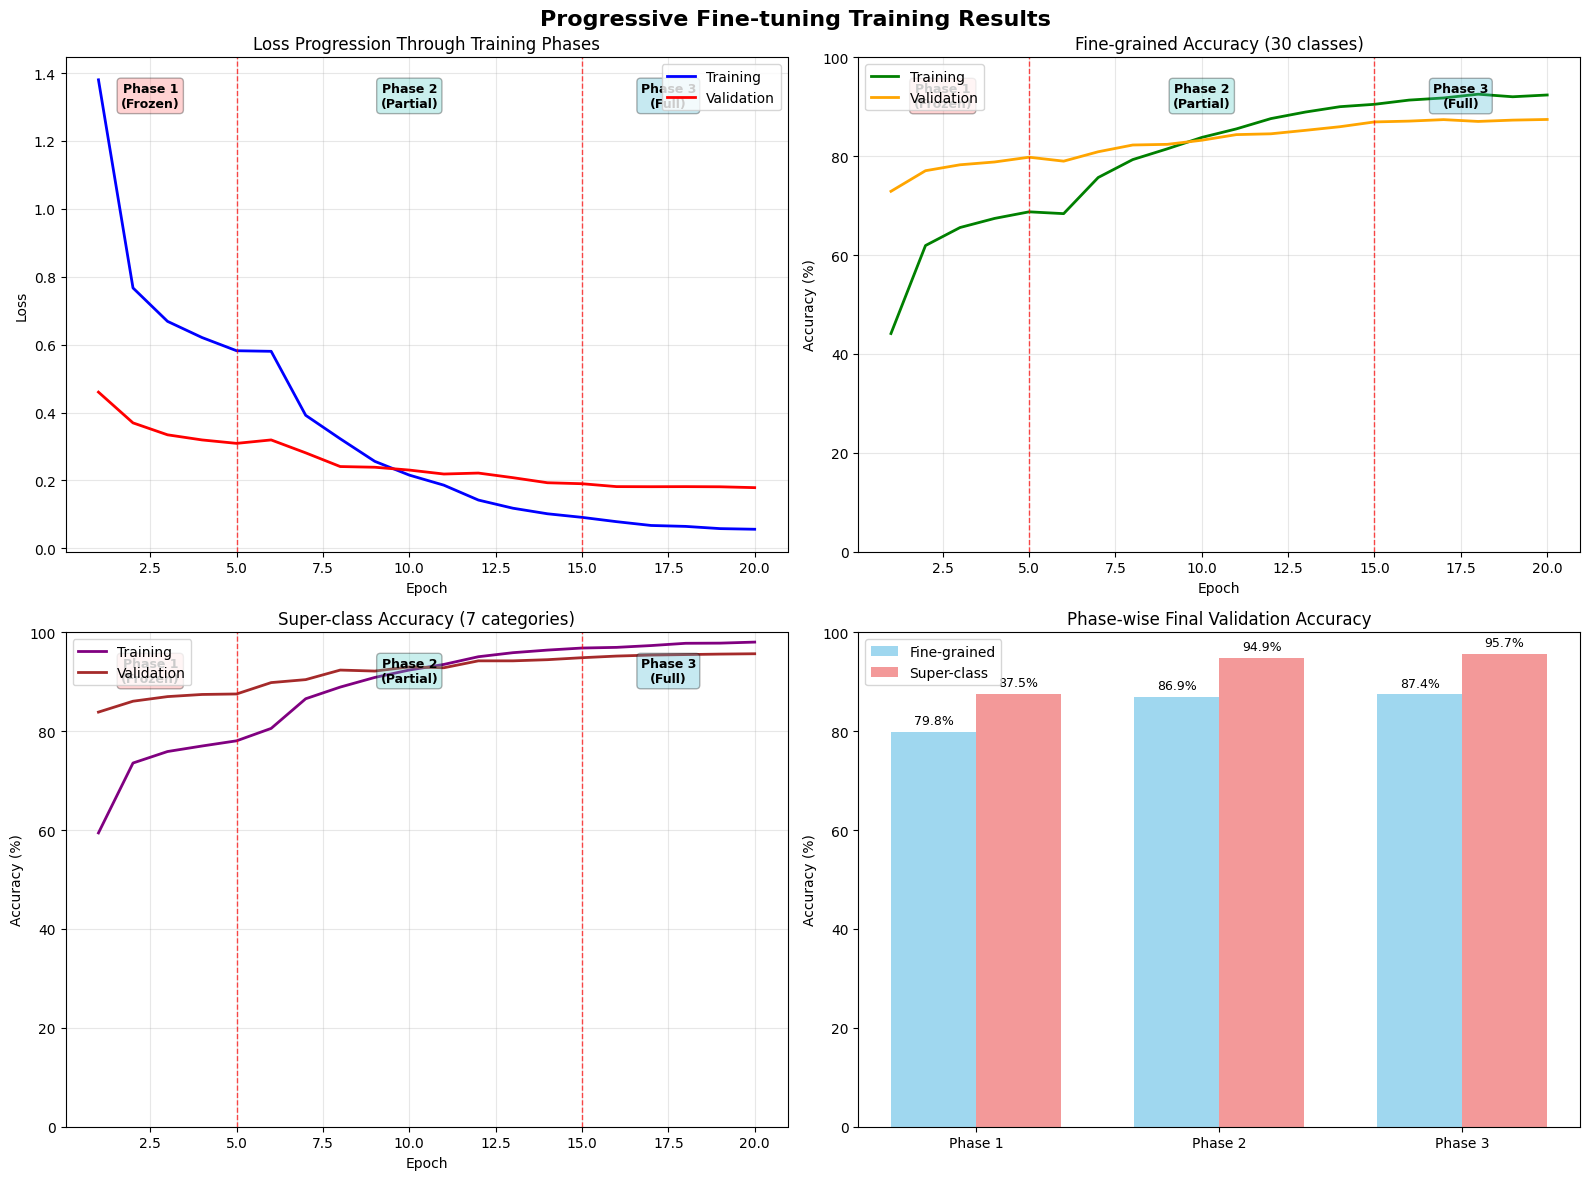


🎯 PROGRESSIVE TRAINING SUMMARY
📈 Best Fine-grained Accuracy: 87.4%
📈 Best Super-class Accuracy: 95.7%
📈 Best Combined Accuracy: 91.6%
📊 Total Training Epochs: 20

📋 Phase-wise Performance:
   Phase 1 (Frozen): Fine 79.8% | Super 87.5% | Combined 83.7%
   Phase 2 (Partial): Fine 86.9% | Super 94.9% | Combined 90.9%
   Phase 3 (Full): Fine 87.4% | Super 95.7% | Combined 91.6%

🏆 Final Performance:
   Fine-grained:  Train 92.4% | Val 87.4%
   Super-class:   Train 98.0% | Val 95.7%
   Combined:      Train 95.2% | Val 91.6%


In [14]:
# Progressive Training Results Visualization

# Clear any previous output artifacts
import sys
sys.stdout.flush()

if 'train_losses' in globals() and len(train_losses) > 0:
    print("Generating Progressive Training Results Visualization...")
    
    epochs = range(1, len(train_losses) + 1)
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Progressive Fine-tuning Training Results', fontsize=16, fontweight='bold')
    
    # Define phase information for visualization
    phase_info = [
        {'name': 'Phase 1\n(Frozen)', 'end': 5, 'color': '#FF6B6B'},
        {'name': 'Phase 2\n(Partial)', 'end': 15, 'color': '#4ECDC4'}, 
        {'name': 'Phase 3\n(Full)', 'end': len(train_losses), 'color': '#45B7D1'}
    ]
    
    # Helper function to add phase boundaries
    def add_phase_boundaries(ax, phase_info):
        prev_end = 0
        for i, phase in enumerate(phase_info):
            # Add vertical line at phase boundary (except for last phase)
            if i < len(phase_info) - 1:
                ax.axvline(x=phase['end'], color='red', linestyle='--', alpha=0.7, linewidth=1)
            
            # Add phase label
            mid_point = prev_end + (phase['end'] - prev_end) / 2
            ax.text(mid_point, ax.get_ylim()[1] * 0.95, phase['name'], 
                   ha='center', va='top', fontsize=9, fontweight='bold',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor=phase['color'], alpha=0.3))
            prev_end = phase['end']
    
    # Loss curves with phase boundaries
    ax1.plot(epochs, train_losses, 'b-', label='Training', linewidth=2)
    ax1.plot(epochs, val_losses, 'r-', label='Validation', linewidth=2)
    ax1.set_title('Loss Progression Through Training Phases')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    add_phase_boundaries(ax1, phase_info)
    
    # Fine-grained accuracy with phase boundaries
    ax2.plot(epochs, train_fine_accs, 'g-', label='Training', linewidth=2)
    ax2.plot(epochs, val_fine_accs, 'orange', label='Validation', linewidth=2)
    ax2.set_title('Fine-grained Accuracy (30 classes)')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 100)
    add_phase_boundaries(ax2, phase_info)
    
    # Super-class accuracy with phase boundaries
    ax3.plot(epochs, train_super_accs, 'purple', label='Training', linewidth=2)
    ax3.plot(epochs, val_super_accs, 'brown', label='Validation', linewidth=2)
    ax3.set_title('Super-class Accuracy (7 categories)')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Accuracy (%)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim(0, 100)
    add_phase_boundaries(ax3, phase_info)
    
    # Phase-wise performance comparison
    if 'phase_boundaries' in globals() and len(phase_boundaries) >= 2:
        # Calculate phase-wise final accuracies
        phase_fine_accs = []
        phase_super_accs = []
        phase_labels = []
        
        boundaries = [0] + phase_boundaries
        for i, (start, end) in enumerate(zip(boundaries[:-1], boundaries[1:])):
            if end <= len(val_fine_accs):
                phase_fine_accs.append(val_fine_accs[end-1])
                phase_super_accs.append(val_super_accs[end-1])
                phase_labels.append(f'Phase {i+1}')
        
        x = np.arange(len(phase_labels))
        width = 0.35
        
        bars1 = ax4.bar(x - width/2, phase_fine_accs, width, label='Fine-grained', alpha=0.8, color='skyblue')
        bars2 = ax4.bar(x + width/2, phase_super_accs, width, label='Super-class', alpha=0.8, color='lightcoral')
        
        ax4.set_title('Phase-wise Final Validation Accuracy')
        ax4.set_ylabel('Accuracy (%)')
        ax4.set_xticks(x)
        ax4.set_xticklabels(phase_labels)
        ax4.legend()
        ax4.set_ylim(0, 100)
        
        # Add value labels on bars
        for bar in bars1:
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height + 1,
                    f'{height:.1f}%', ha='center', va='bottom', fontsize=9)
        
        for bar in bars2:
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height + 1,
                    f'{height:.1f}%', ha='center', va='bottom', fontsize=9)
    else:
        # Fallback to final comparison if phase boundaries not available
        categories = ['Fine-grained', 'Super-class']
        final_train = [train_fine_accs[-1], train_super_accs[-1]]
        final_val = [val_fine_accs[-1], val_super_accs[-1]]
        
        x = np.arange(len(categories))
        width = 0.35
        
        ax4.bar(x - width/2, final_train, width, label='Training', alpha=0.8)
        ax4.bar(x + width/2, final_val, width, label='Validation', alpha=0.8)
        ax4.set_title('Final Accuracy Comparison')
        ax4.set_ylabel('Accuracy (%)')
        ax4.set_xticks(x)
        ax4.set_xticklabels(categories)
        ax4.legend()
        ax4.set_ylim(0, 100)
    
    plt.tight_layout()
    plt.show()
    
    # Progressive Training Summary
    print(f"\n" + "="*60)
    print(f"🎯 PROGRESSIVE TRAINING SUMMARY")
    print(f"="*60)
    print(f"📈 Best Fine-grained Accuracy: {max(val_fine_accs):.1f}%")
    print(f"📈 Best Super-class Accuracy: {max(val_super_accs):.1f}%")
    print(f"📈 Best Combined Accuracy: {(max(val_fine_accs) + max(val_super_accs))/2:.1f}%")
    print(f"📊 Total Training Epochs: {len(train_losses)}")
    
    # Phase-wise improvement analysis
    if 'phase_boundaries' in globals() and len(phase_boundaries) >= 2:
        print(f"\n📋 Phase-wise Performance:")
        boundaries = [0] + phase_boundaries
        phase_names = ["Phase 1 (Frozen)", "Phase 2 (Partial)", "Phase 3 (Full)"]
        
        for i, (start, end) in enumerate(zip(boundaries[:-1], boundaries[1:])):
            if end <= len(val_fine_accs) and i < len(phase_names):
                fine_acc = val_fine_accs[end-1]
                super_acc = val_super_accs[end-1]
                print(f"   {phase_names[i]}: Fine {fine_acc:.1f}% | Super {super_acc:.1f}% | Combined {(fine_acc+super_acc)/2:.1f}%")
    
    print(f"\n🏆 Final Performance:")
    print(f"   Fine-grained:  Train {train_fine_accs[-1]:.1f}% | Val {val_fine_accs[-1]:.1f}%")
    print(f"   Super-class:   Train {train_super_accs[-1]:.1f}% | Val {val_super_accs[-1]:.1f}%")
    print(f"   Combined:      Train {(train_fine_accs[-1]+train_super_accs[-1])/2:.1f}% | Val {(val_fine_accs[-1]+val_super_accs[-1])/2:.1f}%")
    
else:
    print("No training data found. Run the progressive training first.")

## Confusion Matrix Analysis
Generate confusion matrices for both fine-grained (30 classes) and super-class (7 categories) predictions to analyze model performance across different waste types.

Generating Confusion Matrix Analysis...


Generating predictions:   0%|          | 0/47 [00:00<?, ?it/s]

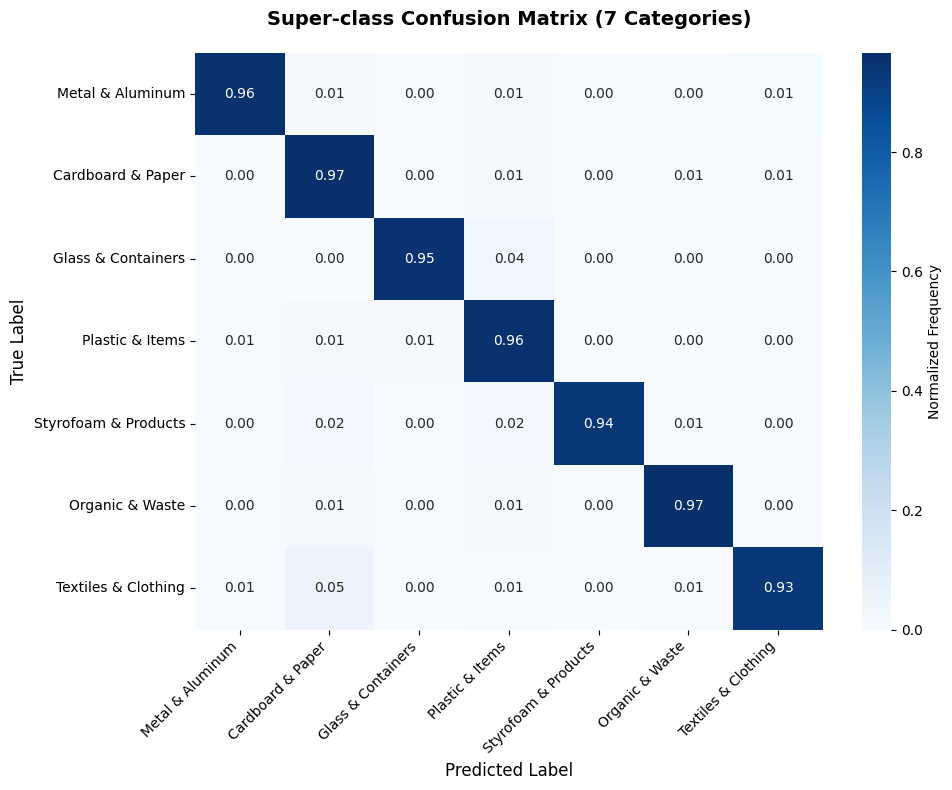

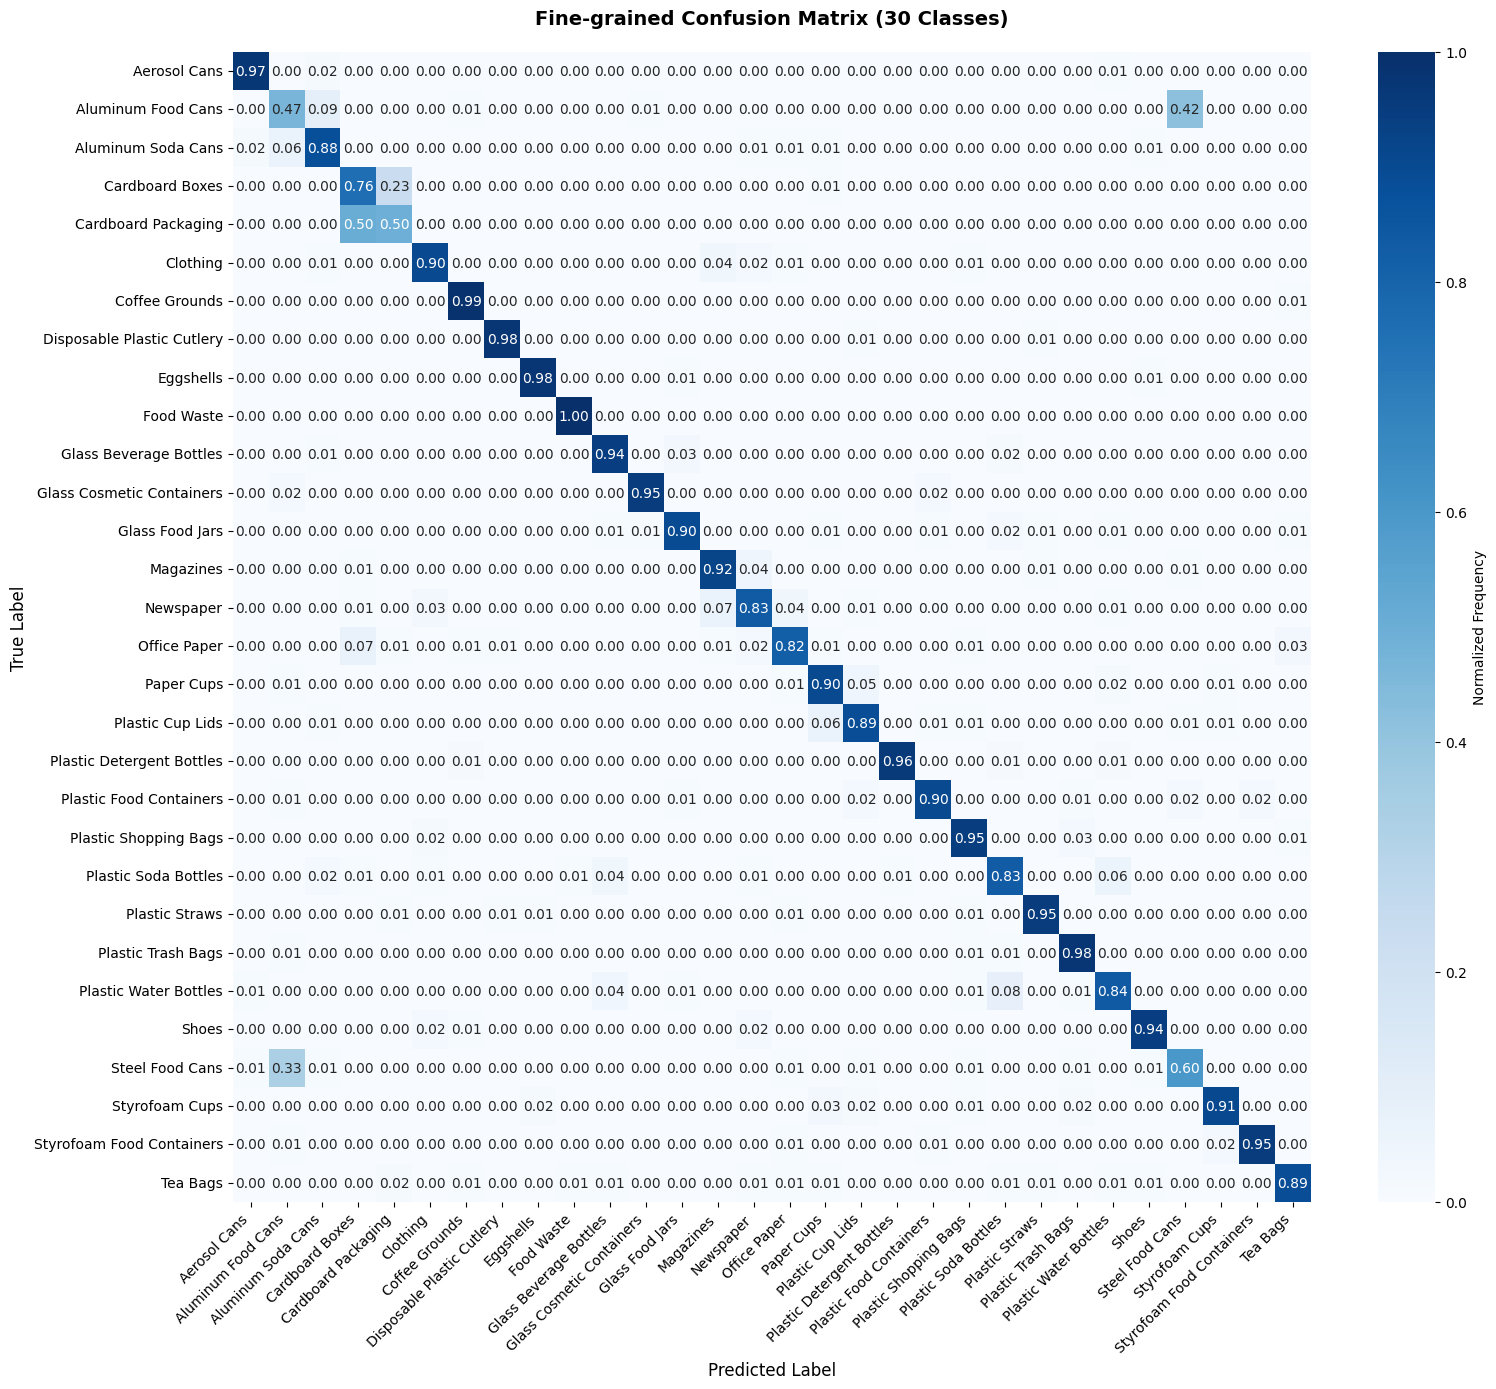


Final Accuracy Summary:
Fine-grained: 87.43%
Super-class: 95.67%


In [15]:
# Confusion Matrix Generation and Visualization

def generate_confusion_matrices(model, test_loader, device, class_names, super_class_names):
    """Generate confusion matrices for both fine-grained and super-class predictions"""
    model.eval()
    
    # Lists to store all predictions and true labels
    all_fine_preds = []
    all_fine_labels = []
    all_super_preds = []
    all_super_labels = []
    
    # Use tqdm with proper cleanup
    pbar = tqdm(test_loader, desc="Generating predictions", leave=False, position=0, dynamic_ncols=True)
    
    try:
        with torch.no_grad():
            for images, fine_labels in pbar:
                images = images.to(device)
                fine_labels = fine_labels.to(device)
                
                # Convert to super labels
                super_labels = torch.tensor([
                    CLASS_IDX_TO_SUPER_IDX.get(int(label), 0) for label in fine_labels.cpu()
                ]).to(device)
                
                # Forward pass
                fine_logits, super_logits = model(images)
                
                # Get predictions
                _, fine_pred = torch.max(fine_logits, 1)
                _, super_pred = torch.max(super_logits, 1)
                
                # Store results
                all_fine_preds.extend(fine_pred.cpu().numpy())
                all_fine_labels.extend(fine_labels.cpu().numpy())
                all_super_preds.extend(super_pred.cpu().numpy())
                all_super_labels.extend(super_labels.cpu().numpy())
    finally:
        # Ensure progress bar is properly closed
        pbar.close()
    
    # Convert to numpy arrays
    all_fine_preds = np.array(all_fine_preds)
    all_fine_labels = np.array(all_fine_labels)
    all_super_preds = np.array(all_super_preds)
    all_super_labels = np.array(all_super_labels)
    
    # Generate confusion matrices
    fine_cm = confusion_matrix(all_fine_labels, all_fine_preds)
    super_cm = confusion_matrix(all_super_labels, all_super_preds)
    
    return fine_cm, super_cm, all_fine_labels, all_fine_preds, all_super_labels, all_super_preds

def plot_confusion_matrix(cm, class_names, title, figsize=(12, 10)):
    """Plot a confusion matrix with proper formatting"""
    plt.figure(figsize=figsize)
    
    # Normalize confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Create heatmap
    sns.heatmap(cm_normalized, 
                annot=True, 
                fmt='.2f', 
                cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names,
                cbar_kws={'label': 'Normalized Frequency'})
    
    plt.title(title, fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Generate confusion matrices if training is complete
if 'waste_classifier' in globals() and 'val_fine_accs' in globals() and len(val_fine_accs) > 0:
    print("Generating Confusion Matrix Analysis...")
    
    # Generate predictions and confusion matrices
    fine_cm, super_cm, fine_labels, fine_preds, super_labels, super_preds = generate_confusion_matrices(
        waste_classifier, test_loader, device, class_names, SUPER_CLASS_NAMES
    )
    
    # Plot super-class confusion matrix (7x7 - more readable)
    super_class_display_names = [name.replace('_', ' & ') for name in SUPER_CLASS_NAMES.values()]
    plot_confusion_matrix(
        super_cm, 
        super_class_display_names,
        'Super-class Confusion Matrix (7 Categories)',
        figsize=(10, 8)
    )
    
    # Plot fine-grained confusion matrix (30x30 - will be dense but informative)
    clean_class_names = [name.replace('_', ' ').title() for name in class_names]
    plot_confusion_matrix(
        fine_cm,
        clean_class_names,
        'Fine-grained Confusion Matrix (30 Classes)',
        figsize=(16, 14)
    )
    
    # Calculate and display accuracy metrics
    fine_accuracy = (fine_preds == fine_labels).mean() * 100
    super_accuracy = (super_preds == super_labels).mean() * 100
    
    print(f"\nFinal Accuracy Summary:")
    print(f"Fine-grained: {fine_accuracy:.2f}%")
    print(f"Super-class: {super_accuracy:.2f}%")
    
else:
    print("No trained model found. Run training first to generate confusion matrices.")

## Final Summary & Cleanup
Training completion summary with best achieved accuracy scores, saved model information, and memory cleanup.

In [16]:
# Final Summary
if 'val_fine_accs' in globals() and len(val_fine_accs) > 0:
    print("Training Complete!")
    print(f"Best Fine-grained Accuracy: {max(val_fine_accs):.1f}%")
    print(f"Best Super-class Accuracy: {max(val_super_accs):.1f}%")
    print(f"Model saved as: best_hierarchical_model.pth")
else:
    print("No training completed yet. Run the training cells to train the model.")

Training Complete!
Best Fine-grained Accuracy: 87.4%
Best Super-class Accuracy: 95.7%
Model saved as: best_hierarchical_model.pth


In [17]:
# Clean Up for GitHub/Kaggle Compatibility
import gc
gc.collect()
print("Cleanup completed")

Cleanup completed
